In [1]:
!pip install deepchem rdkit torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 50.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv, GATConv, EdgeConv, global_mean_pool, SAGPooling, GraphNorm
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
data = pd.read_csv('/kaggle/input/qm9-props/qm9_smiles_properties.csv') 
smiles_list = data['SMILES']
properties = data['G']

In [5]:
def smiles_to_graph(smiles, property_value):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    features = featurizer.featurize([smiles])
    if not features:
        return None

    atom_features = features[0].node_features
    edge_index = torch.tensor(features[0].edge_index, dtype=torch.long)
    edge_features = features[0].edge_features

    x = torch.tensor(atom_features, dtype=torch.float)
    y = torch.tensor([property_value], dtype=torch.float)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

data_list = [smiles_to_graph(smiles, prop) for smiles, prop in zip(smiles_list, properties)]
data_list = [d for d in data_list if d is not None]  

<ipython-input-5-431ab471bb50>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not features:


In [12]:
class GNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dims=[128, 64], 
                 aggr='mean', attn_heads=4, use_attention=True, mlp_layers=[64, 128, 64, 1]):
        """
        Parameters:
        - node_feat_dim: int, Number of node features.
        - edge_feat_dim: int, Number of edge features.
        - hidden_dims: list, Hidden dimensions for each NNConv layer.
        - aggr: str, Aggregation type ('mean', 'sum', 'max').
        - attn_heads: int, Number of attention heads for GAT.
        - use_attention: bool, Whether to apply attention at the end of each layer.
        - mlp_layers: list, Fully connected MLP layers after pooling.
        """
        super(GNN, self).__init__()
        self.num_layers = len(hidden_dims)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        self.edge_nns = torch.nn.ModuleList()
        self.attn_layers = torch.nn.ModuleList()
        
        prev_dim = node_feat_dim
        for i, h_dim in enumerate(hidden_dims):
            # Define the edge network to transform edge features
            edge_nn = Sequential(
                Linear(edge_feat_dim, h_dim),
                ReLU(),
                Linear(h_dim, prev_dim * h_dim)  # output dimensionality will be prev_dim * h_dim
            )
            self.edge_nns.append(edge_nn)
            
            # Define the NNConv layer, passing the edge_nn as the transformation function
            edge_conv = NNConv(in_channels=prev_dim, out_channels=h_dim, 
                               nn=edge_nn, aggr=aggr)
            self.convs.append(edge_conv)
            
            # GraphNorm for normalizing the node features
            self.norms.append(GraphNorm(h_dim))
            
            # Add attention layers if required
            if use_attention:
                self.attn_layers.append(GATConv(h_dim, h_dim // attn_heads, heads=attn_heads, concat=True))
          
            prev_dim = h_dim
        
        # Define the MLP layers after pooling
        mlp_layers_seq = []
        for i in range(len(mlp_layers) - 1):
            mlp_layers_seq.append(Linear(mlp_layers[i], mlp_layers[i + 1]))
            if i < len(mlp_layers) - 2:
                mlp_layers_seq.append(ReLU())
        
        self.mlp = Sequential(*mlp_layers_seq)
    
    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x, edge_index, edge_attr, batch = data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device), data.batch.to(device)
        
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x = conv(x, edge_index, edge_attr).relu()  
            x = norm(x)  
            if len(self.attn_layers) > i:
                x = self.attn_layers[i](x, edge_index).relu() 

        x = global_mean_pool(x, batch)
        
        return self.mlp(x)

In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, max_allowed_increases=5):
    consecutive_increase_counter = 0
    prev_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch).squeeze(-1)
            loss = criterion(outputs, batch.y.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch).squeeze(-1)
                loss = criterion(outputs, batch.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0

        prev_val_loss = avg_val_loss

        if consecutive_increase_counter >= max_allowed_increases:
            print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
            break

    return train_losses, val_losses

In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []

    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            properties = batch.y
            outputs = model(batch).squeeze(-1)
            actual_values.extend(properties.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()

    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)
    
    print(f"Inference time per 1000 samples: {inference_time*1000:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot(
        [min(actual_values), max(actual_values)],
        [min(actual_values), max(actual_values)],
        color="red",
        linestyle="--",
        label="Ideal Fit"
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def run_pipeline(model, data_list, epochs, train_size, batch_size=32):
    train_data, test_data = train_test_split(data_list, test_size=(1 - train_size), random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs
    )

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, test_loader, device)

In [14]:
hidden_dims_opts = [
    [128, 64], [256, 128, 64], [512, 256, 128, 64]
]
attn_heads_opts = [1, 2, 4]
use_attention_opts = [False, True]

hidden_dims_opts_kernel_1 = hidden_dims_opts[:2]  
attn_heads_opts_kernel_1 = attn_heads_opts[:2]  

Training model with hidden_dims=[128, 64], use_attention=False
Epoch [1/100], Train Loss: 5649.4768, Validation Loss: 598.2187
Epoch [2/100], Train Loss: 563.6672, Validation Loss: 509.8886
Epoch [3/100], Train Loss: 511.2497, Validation Loss: 484.0529
Epoch [4/100], Train Loss: 468.3652, Validation Loss: 450.8270
Epoch [5/100], Train Loss: 433.5785, Validation Loss: 470.4686
Epoch [6/100], Train Loss: 403.0997, Validation Loss: 475.6563
Epoch [7/100], Train Loss: 377.8771, Validation Loss: 370.2576
Epoch [8/100], Train Loss: 359.4502, Validation Loss: 352.5030
Epoch [9/100], Train Loss: 345.3636, Validation Loss: 339.1796
Epoch [10/100], Train Loss: 330.5245, Validation Loss: 330.4902
Epoch [11/100], Train Loss: 315.0711, Validation Loss: 332.9805
Epoch [12/100], Train Loss: 306.7401, Validation Loss: 303.2029
Epoch [13/100], Train Loss: 287.5616, Validation Loss: 284.3761
Epoch [14/100], Train Loss: 271.7838, Validation Loss: 264.0174
Epoch [15/100], Train Loss: 251.3149, Validation 

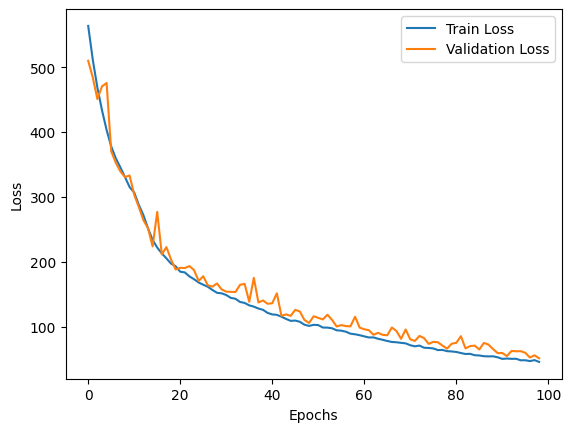

Inference time per 1000 samples: 4.1070
Mean Squared Error (MSE): 51.2473
Mean Absolute Error (MAE): 3.3974
R-Squared (R²): 0.9674


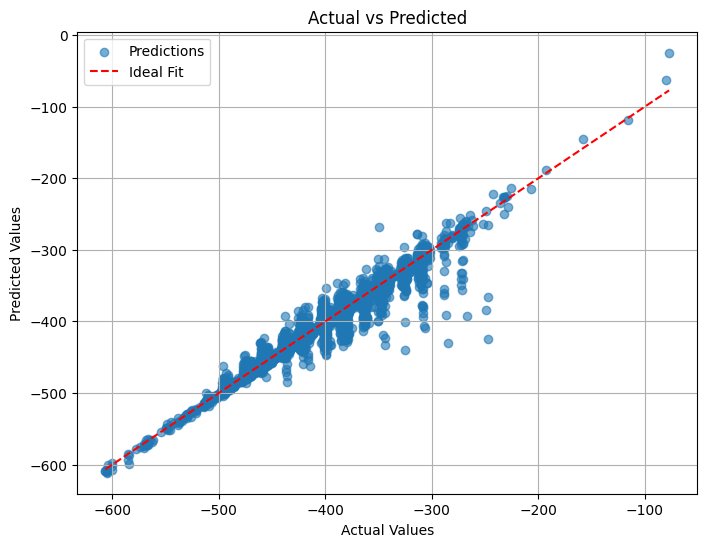

Training model with hidden_dims=[256, 128, 64], use_attention=False


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 5558.4789, Validation Loss: 695.4639
Epoch [2/100], Train Loss: 633.7229, Validation Loss: 622.7605
Epoch [3/100], Train Loss: 508.0010, Validation Loss: 482.4657
Epoch [4/100], Train Loss: 450.8485, Validation Loss: 478.9682
Epoch [5/100], Train Loss: 403.7195, Validation Loss: 370.5561
Epoch [6/100], Train Loss: 365.9780, Validation Loss: 340.1305
Epoch [7/100], Train Loss: 331.0208, Validation Loss: 329.7689
Epoch [8/100], Train Loss: 300.5577, Validation Loss: 280.8203
Epoch [9/100], Train Loss: 274.4731, Validation Loss: 291.4400
Epoch [10/100], Train Loss: 253.9379, Validation Loss: 296.7102
Epoch [11/100], Train Loss: 241.1154, Validation Loss: 234.4417
Epoch [12/100], Train Loss: 218.9272, Validation Loss: 218.2232
Epoch [13/100], Train Loss: 206.5254, Validation Loss: 212.7858
Epoch [14/100], Train Loss: 196.5455, Validation Loss: 183.7721
Epoch [15/100], Train Loss: 183.7932, Validation Loss: 187.6400
Epoch [16/100], Train Loss: 174.4397, Validation

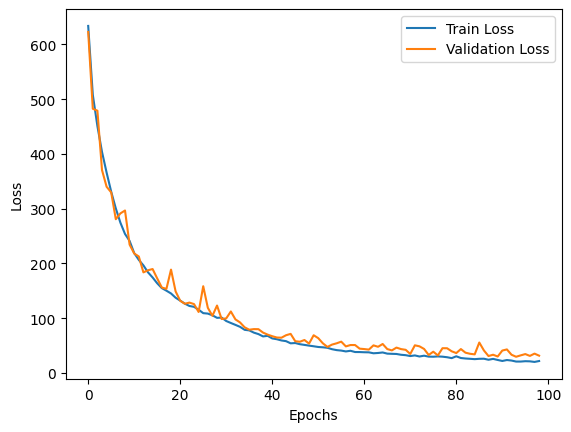

Inference time per 1000 samples: 5.1709
Mean Squared Error (MSE): 21.8349
Mean Absolute Error (MAE): 2.1158
R-Squared (R²): 0.9861


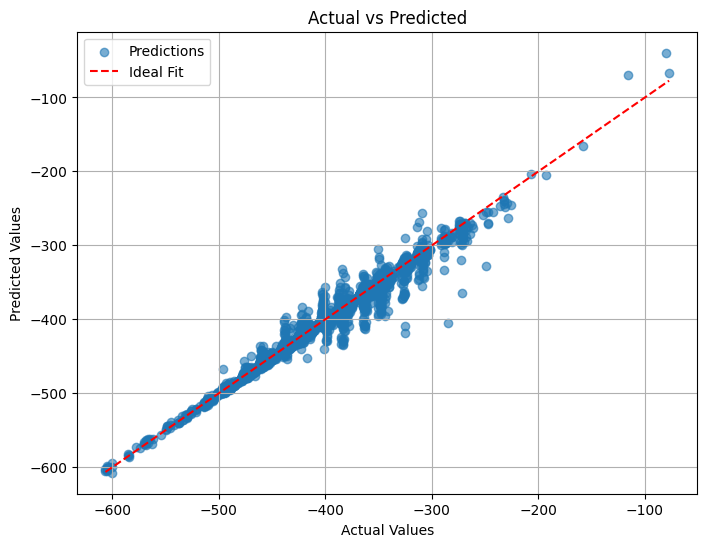

Training model with hidden_dims=[128, 64], attn_heads=1, use_attention=True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3092.7170, Validation Loss: 701.3401
Epoch [2/100], Train Loss: 606.3455, Validation Loss: 637.9142
Epoch [3/100], Train Loss: 533.5144, Validation Loss: 516.6664
Epoch [4/100], Train Loss: 490.6324, Validation Loss: 450.1651
Epoch [5/100], Train Loss: 446.6091, Validation Loss: 502.6049
Epoch [6/100], Train Loss: 412.0117, Validation Loss: 423.1490
Epoch [7/100], Train Loss: 385.7936, Validation Loss: 382.9976
Epoch [8/100], Train Loss: 353.2258, Validation Loss: 390.1469
Epoch [9/100], Train Loss: 327.8793, Validation Loss: 309.0908
Epoch [10/100], Train Loss: 307.1738, Validation Loss: 285.4118
Epoch [11/100], Train Loss: 289.2843, Validation Loss: 263.1095
Epoch [12/100], Train Loss: 268.0620, Validation Loss: 243.0157
Epoch [13/100], Train Loss: 250.4913, Validation Loss: 262.0302
Epoch [14/100], Train Loss: 239.9334, Validation Loss: 284.5651
Epoch [15/100], Train Loss: 225.9289, Validation Loss: 307.3219
Epoch [16/100], Train Loss: 217.8626, Validation

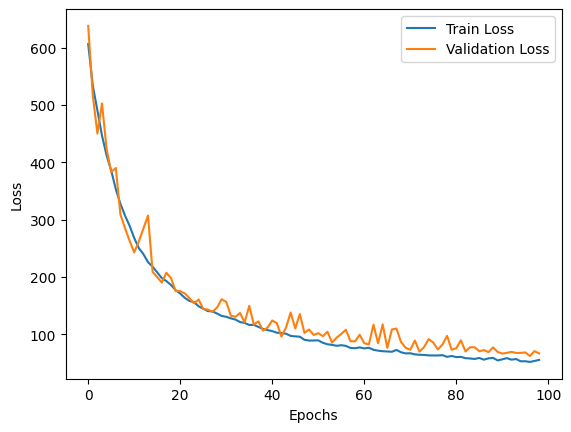

Inference time per 1000 samples: 5.9869
Mean Squared Error (MSE): 49.4238
Mean Absolute Error (MAE): 4.2345
R-Squared (R²): 0.9686


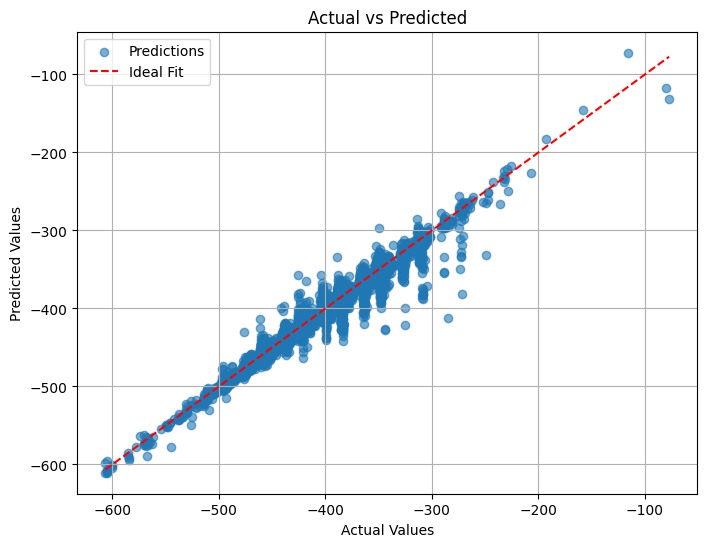

Training model with hidden_dims=[128, 64], attn_heads=2, use_attention=True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3049.6066, Validation Loss: 598.6247
Epoch [2/100], Train Loss: 576.8540, Validation Loss: 506.6134
Epoch [3/100], Train Loss: 493.6117, Validation Loss: 414.0315
Epoch [4/100], Train Loss: 413.3565, Validation Loss: 403.8147
Epoch [5/100], Train Loss: 343.2348, Validation Loss: 379.6472
Epoch [6/100], Train Loss: 298.0902, Validation Loss: 268.4229
Epoch [7/100], Train Loss: 261.3207, Validation Loss: 278.0021
Epoch [8/100], Train Loss: 239.9530, Validation Loss: 217.5723
Epoch [9/100], Train Loss: 219.1286, Validation Loss: 192.1181
Epoch [10/100], Train Loss: 204.7421, Validation Loss: 221.5999
Epoch [11/100], Train Loss: 187.3315, Validation Loss: 215.1139
Epoch [12/100], Train Loss: 172.6524, Validation Loss: 191.6708
Epoch [13/100], Train Loss: 159.9005, Validation Loss: 146.9977
Epoch [14/100], Train Loss: 150.6110, Validation Loss: 153.4318
Epoch [15/100], Train Loss: 138.2880, Validation Loss: 152.7166
Epoch [16/100], Train Loss: 133.8167, Validation

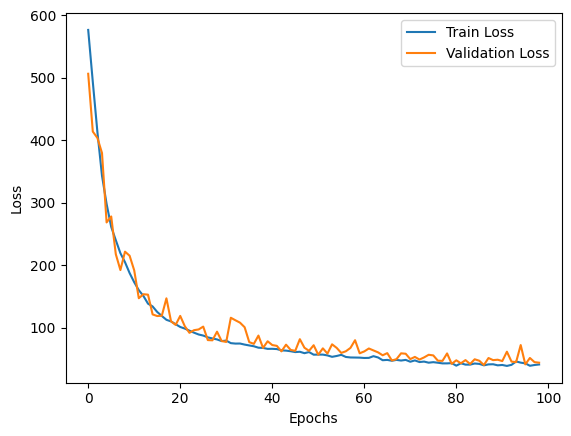

Inference time per 1000 samples: 5.8907
Mean Squared Error (MSE): 46.6205
Mean Absolute Error (MAE): 4.1679
R-Squared (R²): 0.9704


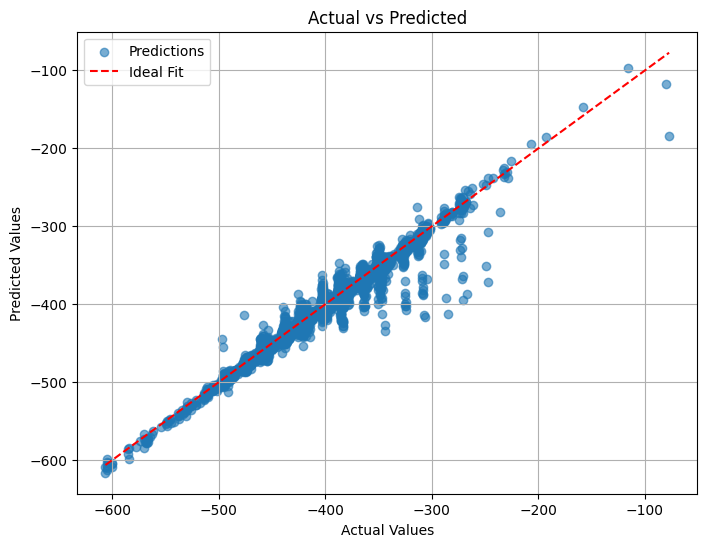

Training model with hidden_dims=[256, 128, 64], attn_heads=1, use_attention=True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3387.2904, Validation Loss: 675.8152
Epoch [2/100], Train Loss: 647.9363, Validation Loss: 904.1449
Epoch [3/100], Train Loss: 574.0295, Validation Loss: 566.4882
Epoch [4/100], Train Loss: 516.0528, Validation Loss: 536.7502
Epoch [5/100], Train Loss: 456.8005, Validation Loss: 450.3656
Epoch [6/100], Train Loss: 426.7926, Validation Loss: 403.1211
Epoch [7/100], Train Loss: 396.7747, Validation Loss: 367.9368
Epoch [8/100], Train Loss: 368.1483, Validation Loss: 343.3838
Epoch [9/100], Train Loss: 329.7121, Validation Loss: 440.9629
Epoch [10/100], Train Loss: 291.7163, Validation Loss: 268.7813
Epoch [11/100], Train Loss: 264.9231, Validation Loss: 308.7929
Epoch [12/100], Train Loss: 248.3288, Validation Loss: 245.1832
Epoch [13/100], Train Loss: 227.5200, Validation Loss: 212.5876
Epoch [14/100], Train Loss: 207.8452, Validation Loss: 187.9532
Epoch [15/100], Train Loss: 188.6108, Validation Loss: 182.1780
Epoch [16/100], Train Loss: 171.1795, Validation

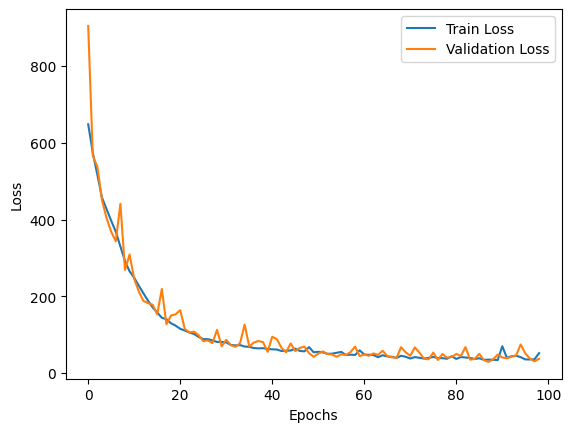

Inference time per 1000 samples: 8.4229
Mean Squared Error (MSE): 34.3177
Mean Absolute Error (MAE): 2.9317
R-Squared (R²): 0.9782


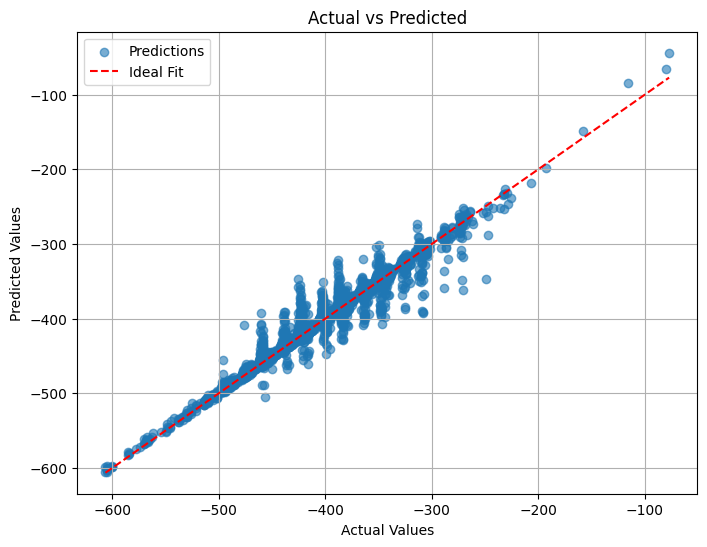

Training model with hidden_dims=[256, 128, 64], attn_heads=2, use_attention=True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 3308.9128, Validation Loss: 665.6785
Epoch [2/100], Train Loss: 598.3943, Validation Loss: 513.6735
Epoch [3/100], Train Loss: 496.5415, Validation Loss: 455.3428
Epoch [4/100], Train Loss: 410.8860, Validation Loss: 368.1930
Epoch [5/100], Train Loss: 336.2623, Validation Loss: 310.3876
Epoch [6/100], Train Loss: 287.4847, Validation Loss: 294.5445
Epoch [7/100], Train Loss: 255.0126, Validation Loss: 211.7399
Epoch [8/100], Train Loss: 226.6053, Validation Loss: 315.0355
Epoch [9/100], Train Loss: 204.8651, Validation Loss: 243.4523
Epoch [10/100], Train Loss: 187.6068, Validation Loss: 165.1531
Epoch [11/100], Train Loss: 162.4496, Validation Loss: 166.0313
Epoch [12/100], Train Loss: 150.8891, Validation Loss: 224.8201
Epoch [13/100], Train Loss: 135.6586, Validation Loss: 124.4970
Epoch [14/100], Train Loss: 124.2001, Validation Loss: 141.7012
Epoch [15/100], Train Loss: 118.1596, Validation Loss: 112.6278
Epoch [16/100], Train Loss: 109.4142, Validation

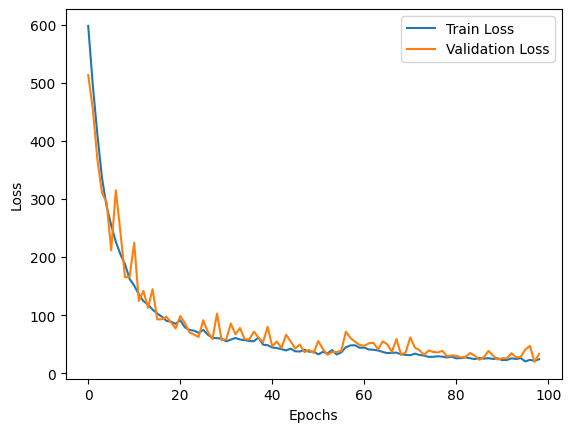

Inference time per 1000 samples: 8.2251
Mean Squared Error (MSE): 33.1079
Mean Absolute Error (MAE): 3.1288
R-Squared (R²): 0.9789


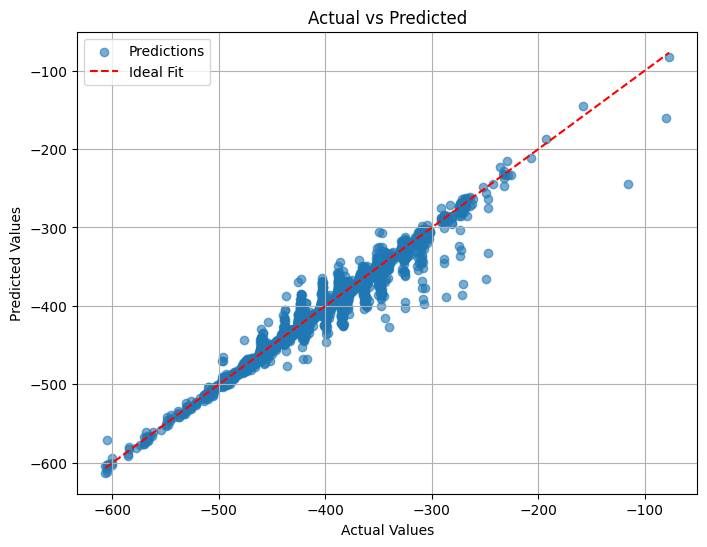

In [16]:
for use_attention in use_attention_opts:
    if use_attention:
        for hidden_dims in hidden_dims_opts_kernel_1:
            for attn_heads in attn_heads_opts_kernel_1:
                print(f"Training model with hidden_dims={hidden_dims}, attn_heads={attn_heads}, use_attention={use_attention}")

                model = GNN(node_feat_dim=30, edge_feat_dim=11, hidden_dims=hidden_dims, attn_heads=attn_heads, use_attention=use_attention)

                run_pipeline(model, data_list, epochs=100, train_size=0.75)
    else:
        for hidden_dims in hidden_dims_opts_kernel_1:
            print(f"Training model with hidden_dims={hidden_dims}, use_attention={use_attention}")

            model = GNN(node_feat_dim=30, edge_feat_dim=11, hidden_dims=hidden_dims, use_attention=use_attention)

            run_pipeline(model, data_list, epochs=100, train_size=0.75)
